In [1]:
import random
import os
import time
import math
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import KDTree
from scipy.stats import wasserstein_distance
import matplotlib
import matplotlib.pyplot as plt
from math import isnan
from scipy.optimize import minimize
import warnings
from sklearn.neighbors import KernelDensity  # display as density curves

import torch
import torch.nn as nn
from torch.nn import init, Module, Parameter  # PyTorch syntax for optimization problems
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd.variable import Variable
from torch.utils.data import DataLoader
#from geomloss import SamplesLoss

In [2]:
#device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device = torch.device('cpu')

In [3]:
set_dist = []
for i in range(100): 
    x = torch.rand(500,1)
    set_dist.append(x)
    
for i in range(35): 
    m = torch.distributions.beta.Beta(torch.tensor([.5]), torch.tensor([.5]))
    x = m.sample([500])
    set_dist.append(x)
    
for i in range(35): 
    m = torch.distributions.beta.Beta(torch.tensor([.7]), torch.tensor([.3]))
    x = m.sample([500])
    set_dist.append(x)
    
for i in range(40): 
    m = torch.distributions.beta.Beta(torch.tensor([.2]), torch.tensor([.7]))
    x = m.sample([500])
    set_dist.append(x)
    
for i in range(50): 
    m = torch.distributions.exponential.Exponential(torch.tensor([1.5]))
    x = m.sample([500])
    set_dist.append(x)
    
for i in range(50): 
    m = torch.distributions.exponential.Exponential(torch.tensor([2.5]))
    x = m.sample([500])
    set_dist.append(x)
    
for i in range(100): 
    m = torch.distributions.gamma.Gamma(torch.tensor([1.0]), torch.tensor([1.5]))
    x = m.sample([500])
    set_dist.append(x)
    
for i in range(40): 
    m = torch.distributions.laplace.Laplace(torch.tensor([1.0]), torch.tensor([1.5]))
    x = m.sample([500])
    set_dist.append(x)
    
for i in range(59): 
    m = torch.distributions.laplace.Laplace(torch.tensor([.5]), torch.tensor([1.0]))
    x = m.sample([500])
    set_dist.append(x)
    
for i in range(100): 
    m = torch.distributions.log_normal.LogNormal(torch.tensor([0.0]), torch.tensor([0.5]))
    x = m.sample([500])
    set_dist.append(x)   

    
for i in range(59): 
    m = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
    x = m.sample([500])
    set_dist.append(x)   

for i in range(50): 
    m = torch.distributions.normal.Normal(torch.tensor([0.3]), torch.tensor([0.5]))
    x = m.sample([500])
    set_dist.append(x)   
    
    
for i in range(100): 
    m = torch.distributions.studentT.StudentT(torch.tensor([2.0]))
    x = m.sample([500])
    set_dist.append(x)      

In [4]:
set_dist = torch.stack(set_dist)

In [5]:
set_dist.shape

torch.Size([818, 500, 1])

In [27]:
class Set2Set(nn.Module):
    def __init__(self, input_dim, hidden_dim, act_fn=nn.Tanh, num_layers=1):
        '''
        Args:
            input_dim: input dim of Set2Set. 
            hidden_dim: the dim of set representation, which is also the INPUT dimension of 
                the LSTM in Set2Set. 
                This is a concatenation of weighted sum of embedding (dim input_dim), and the LSTM
                hidden/output (dim: self.lstm_output_dim).
        '''
        super(Set2Set, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        if hidden_dim <= input_dim:
            print('ERROR: Set2Set output_dim should be larger than input_dim')
        # the hidden is a concatenation of weighted sum of embedding and LSTM output
        self.lstm_output_dim = hidden_dim - input_dim
        self.lstm = nn.LSTM(hidden_dim, input_dim, num_layers=num_layers, batch_first=True)

        # convert back to dim of input_dim
       # self.pred = nn.Linear(hidden_dim, input_dim)
        self.pred = nn.Linear(hidden_dim,4)
        self.act = act_fn()

    def forward(self, embedding):
        '''
        Args:
            embedding: [batch_size x n x d] embedding matrix
        Returns:
            aggregated: [batch_size x d] vector representation of all embeddings
        '''
        batch_size = embedding.size()[0]
        n = embedding.size()[1]

        hidden = (torch.zeros(self.num_layers, batch_size, self.lstm_output_dim).cuda(),
                  torch.zeros(self.num_layers, batch_size, self.lstm_output_dim).cuda())

        q_star = torch.zeros(batch_size, 1, self.hidden_dim).cuda()
        for i in range(n):
            # q: batch_size x 1 x input_dim
            q, hidden = self.lstm(q_star, hidden)
            # e: batch_size x n x 1
            e = embedding @ torch.transpose(q, 1, 2)
            a = nn.Softmax(dim=1)(e)
            r = torch.sum(a * embedding, dim=1, keepdim=True)
            q_star = torch.cat((q, r), dim=2)
        q_star = torch.squeeze(q_star, dim=1)
        out = self.act(self.pred(q_star))

        return out

In [3]:
class DeepSet(nn.Module):

    def __init__(self, in_features, set_features):
        super(DeepSet, self).__init__()
        self.in_features = in_features
        self.out_features = set_features
        self.feature_extractor = nn.Sequential(
            nn.Linear(in_features, 50),
            nn.ELU(inplace=True),
            nn.Linear(50, 100),
            nn.ELU(inplace=True),
            nn.Linear(100, set_features)
        )

        self.regressor = nn.Sequential(
            nn.Linear(set_features, 30),
            nn.ELU(inplace=True),
            nn.Linear(30, 30),
            nn.ELU(inplace=True),
            nn.Linear(30, 10),
            nn.ELU(inplace=True),
            nn.Linear(10, 2),
        )
        
        
    def forward(self, input):
        x = input
        x = self.feature_extractor(x)
        x = x.sum(dim=1)
        x = self.regressor(x)
        return x


In [ ]:
class Encoder(nn.Module):
    """ Set Encoder 
    """
    def __init__(self, dim_Q, dim_K, dim_V, d_model, num_heads, ln=False, skip=True):
        super(Encoder, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.skip = skip
       # self.s_max = s_max
        #Maximum set size
        self.d_model = d_model
        self.fc_q = nn.Linear(dim_Q, d_model)
        self.fc_k = nn.Linear(dim_K, d_model)
        self.fc_v = nn.Linear(dim_K, d_model)
        if ln:
            self.ln0 = nn.LayerNorm(d_model)
            self.ln1 = nn.LayerNorm(d_model)
        #This is the classic pointwise feedforward in "Attention is All you need"
        self.ff = nn.Sequential(
        nn.Linear(d_model, 4 * d_model),
        nn.ReLU(),
        nn.Linear(4 * d_model, d_model))
        # I have experimented with just a smaller version of this 
       # self.fc_o = nn.Linear(d_model,d_model)
        
     #   self.fc_rep = nn.Linear(s_max, 1)
#number of heads must divide output size = d_model
        

    def forward(self, Q, K):
        Q = self.fc_q(Q)
      
        K, V = self.fc_k(K), self.fc_v(K)

        dim_split = self.d_model // self.num_heads
        Q_ = torch.cat(Q.split(dim_split, 2), 0)
        K_ = torch.cat(K.split(dim_split, 2), 0)
        V_ = torch.cat(V.split(dim_split, 2), 0)
  

        A = torch.softmax(Q_.bmm(K_.transpose(-2,-1))/math.sqrt(self.d_model), dim=-1)
        A_1 = A.bmm(V_)
        
 
        O = torch.cat((A_1).split(Q.size(0), 0), 2)
       
        O = torch.cat((Q_ + A_1).split(Q.size(0), 0), 2) if getattr(self, 'skip', True) else \
             torch.cat((A_1).split(Q.size(0), 0), 2)
        O = O if getattr(self, 'ln0', None) is None else self.ln0(O)
       # O = O + F.relu(self.fc_o(O)) if getattr(self, 'skip', None) is None else F.relu(self.fc_o(O))
        # For the classic transformers paper it is 
        O = O + self.ff(O)
        O = O if getattr(self, 'ln1', None) is None else self.ln1(O)
        O = torch.mean(O,dim=1)
#         O = pad_sequence(O, batch_first=True, padding_value=0)
#         O = O.transpose(-2,-1)
#         O = F.pad(O, (0, self.s_max- O.shape[-1]), 'constant', 0)
      #  O = self.fc_rep(O)
       # O = self.fc_rep(O.transpose(-2,-1))
      #  O = O.squeeze()

        return O

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, dim_in=18, dim_out=8, num_heads=2, ln=True, skip=True):
        super(SelfAttention, self).__init__()
        self.Encoder = Encoder(dim_in, dim_in, dim_in, dim_out, num_heads, ln=ln, skip=skip)

    def forward(self, X):
        return self.Encoder(X, X)


In [ ]:
eps = 1e-15
"""Approximating KL divergences between two probability densities using samples. 
    It is buggy. Use at your own peril
"""

def knn_distance(point, sample, k):
    """ Euclidean distance from `point` to it's `k`-Nearest
    Neighbour in `sample` """
    norms = np.linalg.norm(sample-point, axis=1)
    return np.sort(norms)[k]


def verify_sample_shapes(s1, s2, k):
    # Expects [N, D]
    assert(len(s1.shape) == len(s2.shape) == 2)
    # Check dimensionality of sample is identical
    assert(s1.shape[1] == s2.shape[1])


def naive_estimator(s1, s2, k=1):
    """ KL-Divergence estimator using brute-force (numpy) k-NN
        s1: (N_1,D) Sample drawn from distribution P
        s2: (N_2,D) Sample drawn from distribution Q
        k: Number of neighbours considered (default 1)
        return: estimated D(P|Q)
    """
    verify_sample_shapes(s1, s2, k)

    n, m = len(s1), len(s2)
    D = np.log(m / (n - 1))
    d = float(s1.shape[1])

    for p1 in s1:
        nu = knn_distance(p1, s2, k-1)  # -1 because 'p1' is not in 's2'
        rho = knn_distance(p1, s1, k)
        D += (d/n)*np.log((nu/rho)+eps)
    return D


def scipy_estimator(s1, s2, k=1):
    """ KL-Divergence estimator using scipy's KDTree
        s1: (N_1,D) Sample drawn from distribution P
        s2: (N_2,D) Sample drawn from distribution Q
        k: Number of neighbours considered (default 1)
        return: estimated D(P|Q)
    """
    verify_sample_shapes(s1, s2, k)

    n, m = len(s1), len(s2)
    d = float(s1.shape[1])
    D = np.log(m / (n - 1))

    nu_d,  nu_i   = KDTree(s2).query(s1, k)
    rho_d, rhio_i = KDTree(s1).query(s1, k+1)

    # KTree.query returns different shape in k==1 vs k > 1
    if k > 1:
        D += (d/n)*np.sum(np.log(nu_d[::, -1]/rho_d[::, -1]))
    else:
        D += (d/n)*np.sum(np.log(nu_d/rho_d[::, -1]))

    return D


def skl_estimator(s1, s2, k=1):
    """ KL-Divergence estimator using scikit-learn's NearestNeighbours
        s1: (N_1,D) Sample drawn from distribution P
        s2: (N_2,D) Sample drawn from distribution Q
        k: Number of neighbours considered (default 1)
        return: estimated D(P|Q)
    """
    verify_sample_shapes(s1, s2, k)

    n, m = len(s1), len(s2)
    d = float(s1.shape[1])
    D = np.log(m / (n - 1))

    s1_neighbourhood = NearestNeighbors(k+1, 10).fit(s1)
    s2_neighbourhood = NearestNeighbors(k, 10).fit(s2)

    for p1 in s1:
        s1_distances, indices = s1_neighbourhood.kneighbors([p1], k+1)
        s2_distances, indices = s2_neighbourhood.kneighbors([p1], k)
        rho = s1_distances[0][-1]
        nu = s2_distances[0][-1]
        D += (d/n)*np.log(nu/rho)
    return D


# List of all estimators
Estimators = [naive_estimator, scipy_estimator, skl_estimator]

In [15]:
class SinkhornDistance(nn.Module):
    r"""
    Given two empirical measures each with :math:`P_1` locations
    :math:`x\in\mathbb{R}^{D_1}` and :math:`P_2` locations :math:`y\in\mathbb{R}^{D_2}`,
    outputs an approximation of the regularized OT cost for point clouds.
    Args:
        eps (float): regularization coefficient
        max_iter (int): maximum number of Sinkhorn iterations
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Default: 'none'
    Shape:
        - Input: :math:`(N, P_1, D_1)`, :math:`(N, P_2, D_2)`
        - Output: :math:`(N)` or :math:`()`, depending on `reduction`
    """
    def __init__(self, eps, max_iter, reduction='none'):
        super(SinkhornDistance, self).__init__()
        self.eps = eps
        self.max_iter = max_iter
        self.reduction = reduction

    def forward(self, x, y):
        # The Sinkhorn algorithm takes as input three variables :
        C = self._cost_matrix(x, y)  # Wasserstein cost function
        x_points = x.shape[-2]
        y_points = y.shape[-2]
        if x.dim() == 2:
            batch_size = 1
        else:
            batch_size = x.shape[0]

        # both marginals are fixed with equal weights
        mu = torch.empty(batch_size, x_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / x_points).to(device).squeeze()
        nu = torch.empty(batch_size, y_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / y_points).to(device).squeeze()

        u = torch.zeros_like(mu).to(device)
        v = torch.zeros_like(nu).to(device)
        # To check if algorithm terminates because of threshold
        # or max iterations reached
        actual_nits = 0
        # Stopping criterion
        thresh = 1e-1

        # Sinkhorn iterations
        for i in range(self.max_iter):
            u1 = u  # useful to check the update
            u = self.eps * (torch.log(mu+1e-8) - torch.logsumexp(self.M(C, u, v), dim=-1)) + u
            v = self.eps * (torch.log(nu+1e-8) - torch.logsumexp(self.M(C, u, v).transpose(-2, -1), dim=-1)) + v
            err = (u - u1).abs().sum(-1).mean()

            actual_nits += 1
            if err.item() < thresh:
                break

        U, V = u, v
        # Transport plan pi = diag(a)*K*diag(b)
        pi = torch.exp(self.M(C, U, V))
        # Sinkhorn distance
        cost = torch.sum(pi * C, dim=(-2, -1))

        if self.reduction == 'mean':
            cost = cost.mean()
        elif self.reduction == 'sum':
            cost = cost.sum()

        return cost, pi, C
      #  return cost

    def M(self, C, u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(-1) + v.unsqueeze(-2)) / self.eps

    @staticmethod
    def _cost_matrix(x, y, p=1):
        "Returns the matrix of $|x_i-y_j|^p$."
        x_col = x.unsqueeze(-2)
        y_lin = y.unsqueeze(-3)
        C = torch.sum((torch.abs(x_col - y_lin)) ** p, -1)
        return C

    @staticmethod
    def ave(u, u1, tau):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1

In [16]:
sinkhorn = SinkhornDistance(eps=0.1, max_iter=100, reduction=None).to(device)

In [17]:
x = torch.rand(100,1)
y = torch.rand(100,1)

In [19]:
sinkhorn(x,y)

(tensor(0.1360),
 tensor([[2.3561e-05, 1.3045e-04, 1.5212e-05,  ..., 2.2476e-04, 1.2671e-05,
          1.0132e-04],
         [1.0644e-04, 1.6076e-05, 1.2171e-04,  ..., 5.6677e-05, 1.3154e-04,
          1.2486e-05],
         [1.5175e-04, 2.2919e-05, 1.7353e-04,  ..., 8.0803e-05, 1.8754e-04,
          1.7801e-05],
         ...,
         [2.0375e-04, 3.0772e-05, 2.3298e-04,  ..., 1.0849e-04, 2.5179e-04,
          2.3900e-05],
         [7.1731e-05, 9.2765e-05, 4.6313e-05,  ..., 3.2705e-04, 3.8576e-05,
          7.2047e-05],
         [1.6496e-05, 1.3937e-04, 1.0650e-05,  ..., 1.5736e-04, 8.8711e-06,
          1.0824e-04]]),
 tensor([[0.1801, 0.2726, 0.2087,  ..., 0.0358, 0.2217, 0.3556],
         [0.2201, 0.6727, 0.1915,  ..., 0.3644, 0.1785, 0.7558],
         [0.1617, 0.6143, 0.1331,  ..., 0.3060, 0.1201, 0.6974],
         ...,
         [0.1124, 0.5650, 0.0838,  ..., 0.2567, 0.0708, 0.6481],
         [0.1074, 0.3453, 0.1360,  ..., 0.0369, 0.1490, 0.4283],
         [0.2012, 0.2514, 0.2298, 

In [20]:
sinkhorn.ave()

TypeError: ave() missing 3 required positional arguments: 'u', 'u1', and 'tau'

In [13]:
sinkhorn(x,y)

tensor(0.0398)

In [14]:
sinkhorn(y,x)

tensor(0.0398)

In [ ]:
sinkhorn.

In [6]:
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data.float()
        
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        
        if self.transform:
            x = self.transform(x)
           
        return x

    def __len__(self):
        return len(self.data)
    

In [10]:
dataset = MyDataset(set_dist)
loader = DataLoader(dataset, batch_size = 12, shuffle = True)

In [5]:
model = DeepSet(1, 36).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# checkpoint = torch.load('/Users/arijitsehanobish/set_stuff/deepset_dist_flat6.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# loss = checkpoint['loss']

model.load_state_dict(torch.load('/Users/arijitsehanobish/set_stuff/deepset_dist_flat6.pkl'))
#model.train()
model.eval()

DeepSet(
  (feature_extractor): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=100, out_features=36, bias=True)
  )
  (regressor): Sequential(
    (0): Linear(in_features=36, out_features=30, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=30, out_features=10, bias=True)
    (5): ELU(alpha=1.0, inplace=True)
    (6): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [9]:
x = torch.rand(1,500,1)
y = torch.rand(1,500,1)
z = torch.rand(1,500,1)

In [10]:
model(x)

tensor([[-1.8933, -0.0028]], grad_fn=<AddmmBackward>)

In [11]:
model(y)

tensor([[-1.8789, -0.0102]], grad_fn=<AddmmBackward>)

In [12]:
model(z)

tensor([[-1.8672, -0.0164]], grad_fn=<AddmmBackward>)

Wasserstein distance has the following properties: 
1) W(aX,aY) = |a|W(X,Y)
2) W(X+x, Y+x) = W(X,Y)
3) The space equipped with W_1 is flat. 
Next step is to implement these properties
Open Question: Do we construct an isometry between the space of distributions and our encoded space?

In [12]:
num_epochs = 500
running_loss = []
for t in range(num_epochs):
    for n_batch, batch in enumerate(loader):
        n_data = Variable(batch.to(device), requires_grad=True)
        a = torch.rand(1).to(device)
        b = torch.rand(1).to(device)
       
    
        optimizer.zero_grad()
        y = model(n_data)
        y_a = model(a*n_data)
        y_translate = model(n_data + b)
        
        loss = 0
       
        for i in range(len(batch)):
            for j in range(i+1,len(batch)):
                
                y_ij = torch.norm(y[i]-y[j], p=2)
                w_ij = sinkhorn(n_data[i],n_data[j]) 
                
                ya_ij = torch.norm(y_a[i]-y_a[j], p=2)
                y_translate_ij = torch.norm(y_translate[i]-y_translate[j], p=2)
                
                diff_translate_ij = torch.norm(y_translate[i]-y[j], p=2)**2
                
    
                loss += torch.norm(y_ij-w_ij, p=2) + (ya_ij-a*y_ij)**2 + (y_translate_ij- y_ij)**2
                
                del w_ij
        #TODO FIX THE LAST TERMS WITH PAIRWISE DISTANCES (SEE PYTORCH CODE)
        
        
        loss = loss/(len(batch)*(len(batch)-1)/2)
       
        loss.backward()
       
        optimizer.step()
    
        
    running_loss.append(loss)
    print(loss)
   
   

tensor([0.0104], grad_fn=<DivBackward0>)
tensor([0.0094], grad_fn=<DivBackward0>)
tensor([0.0240], grad_fn=<DivBackward0>)
tensor([0.0199], grad_fn=<DivBackward0>)
tensor([0.0869], grad_fn=<DivBackward0>)
tensor([0.0075], grad_fn=<DivBackward0>)
tensor([0.0272], grad_fn=<DivBackward0>)
tensor([0.0164], grad_fn=<DivBackward0>)
tensor([0.0053], grad_fn=<DivBackward0>)
tensor([0.1072], grad_fn=<DivBackward0>)
tensor([0.0081], grad_fn=<DivBackward0>)
tensor([0.0188], grad_fn=<DivBackward0>)
tensor([0.0465], grad_fn=<DivBackward0>)
tensor([0.0815], grad_fn=<DivBackward0>)
tensor([0.1111], grad_fn=<DivBackward0>)
tensor([0.0242], grad_fn=<DivBackward0>)
tensor([0.0098], grad_fn=<DivBackward0>)
tensor([0.0734], grad_fn=<DivBackward0>)
tensor([0.0312], grad_fn=<DivBackward0>)
tensor([0.0405], grad_fn=<DivBackward0>)
tensor([0.0197], grad_fn=<DivBackward0>)
tensor([0.0310], grad_fn=<DivBackward0>)
tensor([0.0165], grad_fn=<DivBackward0>)
tensor([0.0968], grad_fn=<DivBackward0>)
tensor([0.0345],

KeyboardInterrupt: 

In [29]:
#flat1 pkl is after 25 epochs, do not just pkl but save everything as in the next block, flat2 is after 33 epochs, flat3 is after 72 epochs
#4th save is after 75 epochs, 5th is after 72 epochs, 6th after 73 epochs. Seems have to have converged. 
torch.save(model.state_dict(),'deepset_dist_flat6.pkl')

In [30]:
#3rd save is after 72 epochs, 4th save is after 75 epochs
torch.save({
    
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            
            }, 'deepset_dist_flat6.pt')

In [13]:
len(running_loss)

73

In [19]:
running_loss

[tensor([0.0808], grad_fn=<DivBackward0>),
 tensor([0.0235], grad_fn=<DivBackward0>),
 tensor([0.0178], grad_fn=<DivBackward0>),
 tensor([0.0036], grad_fn=<DivBackward0>),
 tensor([0.1610], grad_fn=<DivBackward0>),
 tensor([0.0092], grad_fn=<DivBackward0>),
 tensor([0.0047], grad_fn=<DivBackward0>),
 tensor([0.2086], grad_fn=<DivBackward0>),
 tensor([0.0592], grad_fn=<DivBackward0>),
 tensor([0.0015], grad_fn=<DivBackward0>),
 tensor([0.0263], grad_fn=<DivBackward0>),
 tensor([0.0828], grad_fn=<DivBackward0>),
 tensor([0.0137], grad_fn=<DivBackward0>),
 tensor([0.0381], grad_fn=<DivBackward0>),
 tensor([0.0882], grad_fn=<DivBackward0>),
 tensor([0.0032], grad_fn=<DivBackward0>),
 tensor([0.0063], grad_fn=<DivBackward0>),
 tensor([0.0171], grad_fn=<DivBackward0>),
 tensor([0.0097], grad_fn=<DivBackward0>),
 tensor([0.0340], grad_fn=<DivBackward0>),
 tensor([0.0356], grad_fn=<DivBackward0>),
 tensor([0.0754], grad_fn=<DivBackward0>),
 tensor([0.0561], grad_fn=<DivBackward0>),
 tensor([0.

In [21]:
x=torch.rand(1,500,1)
y = torch.rand(1,500,1)

In [22]:
model(x)

tensor([[-1.8918, -0.0027]], grad_fn=<AddmmBackward>)

In [23]:
model(y)

tensor([[-1.8848, -0.0050]], grad_fn=<AddmmBackward>)

In [24]:
m = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
m1 = m.sample([500]).view(1,-1,1)

In [25]:
model(m1)

tensor([[-2.1955,  0.6966]], grad_fn=<AddmmBackward>)

In [26]:
m2 = m.sample([500]).view(1,-1,1)

In [27]:
model(m2)

tensor([[-2.2358,  0.7247]], grad_fn=<AddmmBackward>)

In [28]:
n = torch.distributions.normal.Normal(torch.tensor([.05]), torch.tensor([1.0]))

In [29]:
n1 = n.sample([500]).view(1,-1,1)

In [30]:
model(n1)

tensor([[-2.2100,  0.6603]], grad_fn=<AddmmBackward>)

In [33]:
n2 = n.sample([500]).view(1,-1,1)

In [34]:
model(n2)

tensor([[-2.1499,  0.7050]], grad_fn=<AddmmBackward>)

In [35]:
N = torch.distributions.normal.Normal(torch.tensor([.5]), torch.tensor([.75]))
N1 = N.sample([500]).view(1,-1,1)
N2 = N.sample([500]).view(1,-1,1)

In [85]:
E = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([.5]))
e = E.sample([500]).view(1,-1,1)

In [87]:
F = torch.distributions.normal.Normal(torch.tensor([.5]), torch.tensor([.5]))
f = F.sample([500]).view(1,-1,1)
model(f)

tensor([[-1.8970,  0.1355]], grad_fn=<AddmmBackward>)

In [86]:
model(e)

tensor([[-2.3010,  0.3002]], grad_fn=<AddmmBackward>)

In [36]:
model(N1)

tensor([[-1.8139,  0.3373]], grad_fn=<AddmmBackward>)

In [37]:
model(N2)

tensor([[-1.8100,  0.2864]], grad_fn=<AddmmBackward>)

In [38]:
A = torch.ones(500).view(1,-1,1)
B = torch.zeros(500).view(1,-1,1)

In [39]:
model(A)

tensor([[-1.4259, -0.1707]], grad_fn=<AddmmBackward>)

In [40]:
model(B)

tensor([[-2.3787,  0.1273]], grad_fn=<AddmmBackward>)

In [41]:
#distance between the above points is d = 0.998314
sinkhorn(A,B)

tensor([0.9999])

In [42]:
C = torch.distributions.bernoulli.Bernoulli(torch.tensor([.3]))
D = torch.distributions.bernoulli.Bernoulli(torch.tensor([.5]))

In [80]:
C1 = C.sample([500]).view(1,-1,1)
D1 = D.sample([500]).view(1,-1,1)

In [81]:
model(C1)

tensor([[-2.0647,  0.2234]], grad_fn=<AddmmBackward>)

In [82]:
model(D1)

tensor([[-1.8704,  0.1438]], grad_fn=<AddmmBackward>)

In [83]:
#Correct answer is .2, and we get .29
sinkhorn(C1,D1)

tensor([0.2078])

In [16]:
t_plot = np.linspace(-0.1, 1.1, 1000)[:,np.newaxis]

def display_samples(ax, x, color, weights=None, blur=.002):
    """Displays samples on the unit interval using a density curve."""
    kde  = KernelDensity(kernel='gaussian', bandwidth= blur ).fit(
            x.data.cpu().numpy(),
            sample_weight = None if weights is None else weights.data.cpu().numpy())
    dens = np.exp( kde.score_samples(t_plot) )
    dens[0] = 0 ; dens[-1] = 0
    ax.fill(t_plot, dens, color=color)

In [18]:
warnings.filterwarnings("ignore",".*GUI is implemented.*") # annoying warning with pyplot and pause...

def mypause(interval):
    """Pause matplotlib without stealing focus."""
    backend = plt.rcParams['backend']
    if backend in matplotlib.rcsetup.interactive_bk:
        figManager = matplotlib._pylab_helpers.Gcf.get_active()
        if figManager is not None:
            canvas = figManager.canvas
            if canvas.figure.stale:
                canvas.draw()
            canvas.start_event_loop(interval)
            return


def model_to_numpy(model, grad=False) :
    """
    The fortran routines used by scipy.optimize expect float64 vectors
    instead of the gpu-friendly float32 matrices: we need conversion routines.
    """
    if not all( param.is_contiguous() for param in model.parameters() ) :
        raise ValueError("Scipy optimization routines are only compatible with parameters given as *contiguous* tensors.")

    if grad :
        tensors = [param.grad.data.view(-1).cpu().numpy() for param in model.parameters()]
    else :
        tensors = [param.data.view(-1).cpu().numpy()      for param in model.parameters()]
    return np.ascontiguousarray( np.hstack(tensors) , dtype='float64' )

def numpy_to_model(model, vec) :
    i = 0
    for param in model.parameters() :
        offset = param.numel()
        param.data = torch.from_numpy(vec[i:i+offset]).view(param.data.size()).type(param.data.type())
        i += offset

    if i != len(vec) :
        raise ValueError("The total number of variables in model is not the same as in 'vec'.")

def fit_model(Model, method = "L-BFGS", tol = 1e-10, nits = 500, nlogs = 10,
                     lr = .1, eps = .01, maxcor = 10, gtol = 1e-10, 
                     display = False, **params) :
    """
    """

    # Load parameters =====================================================================================================


    # We'll minimize the model's cost
    # with respect to the model's parameters using a standard gradient-like
    # descent scheme. As we do not perform any kind of line search, 
    # this algorithm may diverge if the learning rate is too large !
    # For robust optimization routines, you may consider using
    # the scipy.optimize API with a "parameters <-> float64 vector" wrapper.
    use_scipy = False
    if method == "Adam" :
        optimizer = torch.optim.Adam(Model.parameters(), lr=lr, eps=eps)
    elif method == "L-BFGS" :
        optimizer = torch.optim.SGD(Model.parameters(), lr=1.) # We'll just use its "zero_grad" method...

        use_scipy = True
        method    = 'L-BFGS-B'
        options   = dict( maxiter = nits,
                          ftol    = tol,          # Don't bother fitting the shapes to float precision
                          gtol    = gtol,
                          maxcor  = maxcor        # Number of previous gradients used to approximate the Hessian
                    )
    else :
        raise NotImplementedError('Optimization method not supported : "'+method+'". '\
                                  'Available values are "Adam" and "L-BFGS".')

    costs = []
    # Define the "closures" associated to our model =======================================================================

    fit_model.nit = -1 ; fit_model.breakloop = False
    def closure(final_it=False):
        """
        Encapsulates a problem + display iteration into a single callable statement.
        This wrapper is needed if you choose to use LBFGS-like algorithms, which
        (should) implement a careful line search along the gradient's direction.
        """
        fit_model.nit += 1 ; it = fit_model.nit
        # Minimization loop --------------------------------------------------------------------
        optimizer.zero_grad()                      # Reset the gradients (PyTorch syntax...).
        cost = Model.forward()
        costs.append(cost.item())  # Store the "cost" for plotting.
        cost.backward()            # Backpropagate to compute the gradient.
        # Break the loop if the cost's variation is below the tolerance param:
        if ( len(costs)>1 and abs(costs[-1]-costs[-2]) < tol ) or fit_model.nit == nits-1:
            fit_model.breakloop = True
        
        if display:

            Model.plot(nit=fit_model.nit, cost=cost.item())
            # print("{}: {:2.4f}".format(fit_model.nit, cost.item()))
        return cost
    
    # Scipy-friendly wrapper ------------------------------------------------------------------------------------------------
    def numpy_closure(vec, final_it=False) :
        """
        Wraps the PyTorch closure into a 'float64'-vector routine,
        as expected by scipy.optimize.
        """
        vec    = lr * vec.astype('float64')            # scale the vector, and make sure it's given as float64
        numpy_to_model(Model, vec)                     # load this info into Model's parameters
        c      = closure(final_it).item()              # compute the cost and accumulate the gradients wrt. the parameters
        dvec_c = lr * model_to_numpy(Model, grad=True) # -> return this gradient, as a properly rescaled numpy vector
        return (c, dvec_c)

    # Actual minimization loop ===============================================================================================
    if use_scipy :
        res = minimize( numpy_closure,      # function to minimize
                model_to_numpy(Model), # starting estimate
                method  = method,
                jac     = True,             # matching_problems also returns the gradient
                options = options    )
        numpy_closure(res.x, final_it=True) 
        # print(res.message)
    else :
        for i in range(nits+1) :            # Fixed number of iterations
            optimizer.step(closure)         # "Gradient descent" step.
            if fit_model.breakloop :
                closure(final_it=True) 
                break
            

In [19]:
class Barycenter(Module):
    """Abstract model for the computation of Sinkhorn barycenters."""

    def __init__(self, loss, w=.5):
        super(Barycenter, self).__init__()
        self.loss = loss   # Sinkhorn divergence to optimize
        self.w = w         # Interpolation coefficient
        # We copy the reference starting points, to prevent in-place modification:
        self.x_i, self.y_j, self.z_k = X_i.clone(), Y_j.clone(), Z_k.clone()

    def fit(self, display=False, tol=1e-10):
        """Uses a custom wrapper around the scipy.optimize module."""
        fit_model(self, method = "L-BFGS", lr = 1., display = display, tol=tol, gtol=tol)

    def weights(self):
        """The default weights are uniform, equal to 1/N."""
        return (torch.ones(len(self.z_k)) / len(self.z_k)).type_as(self.z_k)

    def plot(self, nit=0, cost=0, ax=None, title=None):
        """Displays the descent using a custom 'waffle' layout.

        N.B.: As the L-BFGS descent typically induces high-frequencies in
              the optimization process, we blur the 'interpolating' measure
              a little bit more than the two endpoints.
        """
        if ax is None:
            if nit == 0 or nit % 16 == 4:
                plt.pause(.01)
                plt.figure(figsize=(16,4))

            if nit <= 4 or nit % 4 == 0:
                if nit < 4: index = nit + 1
                else:       index = (nit//4 - 1) % 4 + 1
                ax = plt.subplot(1,4, index)

        if ax is not None:
            display_samples(ax, self.x_i, (.95,.55,.55))
            display_samples(ax, self.y_j, (.55,.55,.95))
            display_samples(ax, self.z_k, (.55,.95,.55), weights = self.weights(), blur=.005)

            if title is None:
                ax.set_title("nit = {}, cost = {:3.4f}".format(nit, cost))
            else:
                ax.set_title(title)

            ax.axis([-.1,1.1,-.1,20.5])
            ax.set_xticks([], []); ax.set_yticks([], [])
            plt.tight_layout()


class EulerianBarycenter(Barycenter) :
    """Barycentric model with fixed locations z_k, as we optimize on the log-weights l_k."""
    def __init__(self, loss, w=.5) :
        super(EulerianBarycenter, self).__init__(loss, w)

        # We're going to work with variable weights, so we should explicitely
        # define the (uniform) weights on the "endpoint" samples:
        self.a_i = (torch.ones(len(self.x_i)) / len(self.x_i)).type_as(self.x_i)
        self.b_j = (torch.ones(len(self.y_j)) / len(self.y_j)).type_as(self.y_j)

        # Our parameter to optimize: the logarithms of our weights
        self.l_k = Parameter( torch.zeros(len(self.z_k)).type_as(self.z_k) )

    def weights(self):
        """Turns the l_k's into the weights of a positive probabilty measure."""
        return torch.nn.functional.softmax(self.l_k, dim=0)

    def forward(self) :
        """Returns the cost to minimize."""
        c_k  = self.weights()
        return self.w  * self.loss(c_k, self.z_k, self.a_i, self.x_i) \
        + (1 - self.w) * self.loss(c_k, self.z_k, self.b_j, self.y_j)

In [48]:
X_i, Y_j = N.sample([500]).view(-1,1), m.sample([500]).view(-1,1)
t_k = torch.linspace(-2, 2, 500).view(-1,1)
Z_k = t_k

In [49]:
EB = EulerianBarycenter( SamplesLoss("sinkhorn", p=1, blur=.01, scaling=.9) )

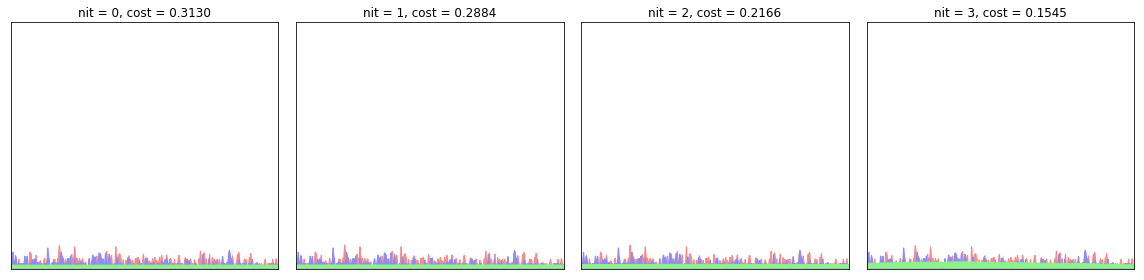

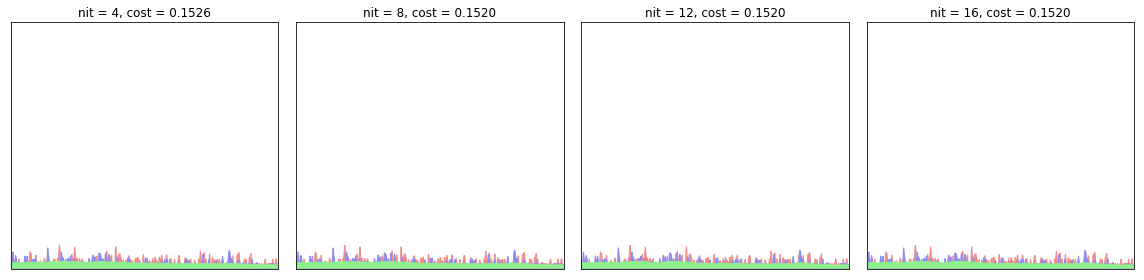

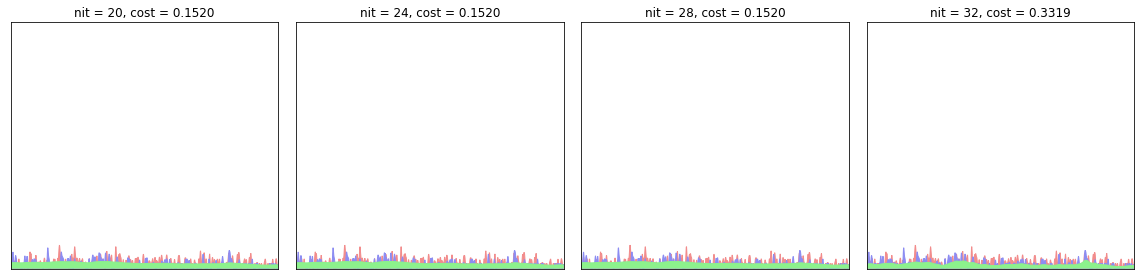

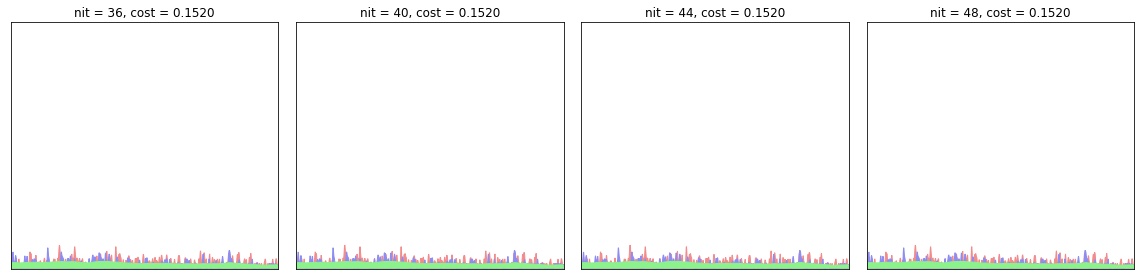

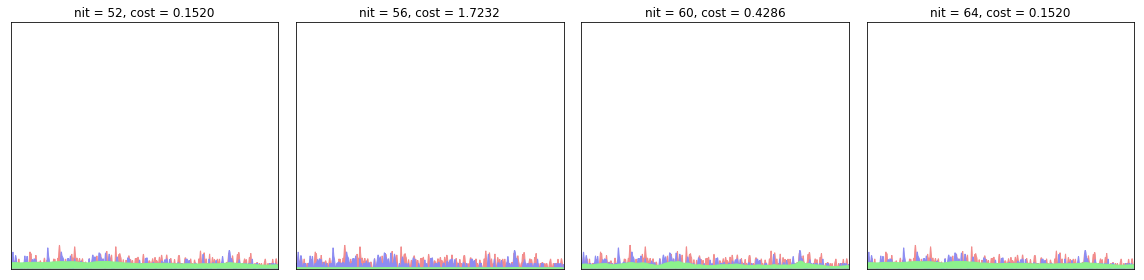

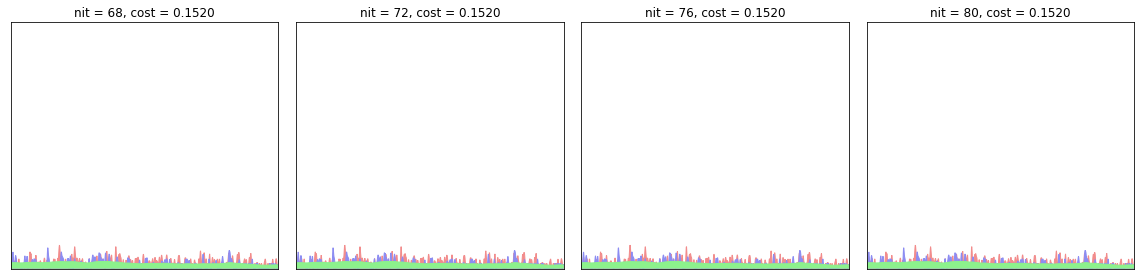

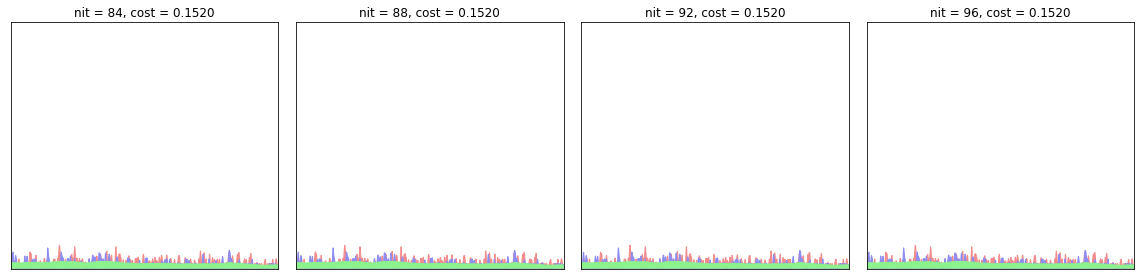

In [50]:
EB.fit(display=True)

In [51]:
class LagrangianBarycenter(Barycenter) :
    def __init__(self, loss, w=.5) :
        super(LagrangianBarycenter, self).__init__(loss, w)

        # Our parameter to optimize: the locations of the input samples
        self.z_k = Parameter( Z_k.clone() )

    def forward(self) :
        """Returns the cost to minimize."""
        # By default, the weights are uniform and sum up to 1:
        return self.w  * self.loss( self.z_k, self.x_i) \
        + (1 - self.w) * self.loss( self.z_k, self.y_j)

In [53]:
LB = LagrangianBarycenter( SamplesLoss("sinkhorn", p=1, blur=.01, scaling=.9) )

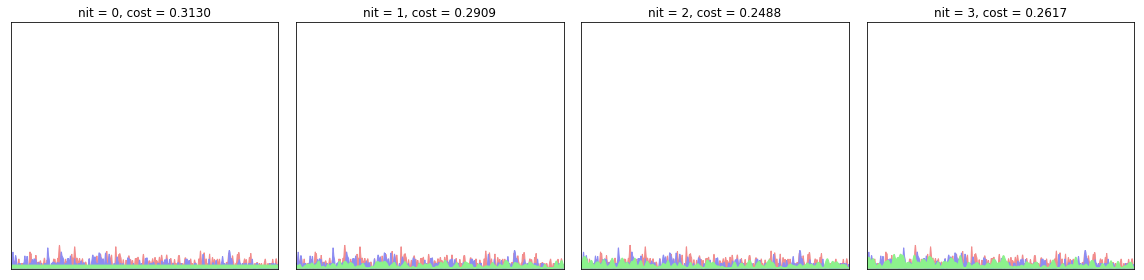

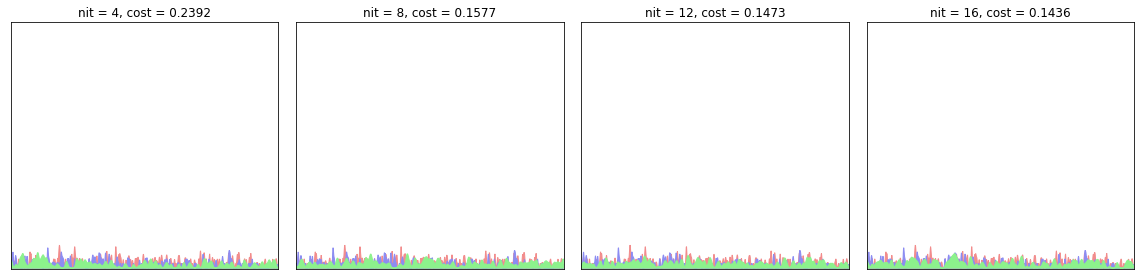

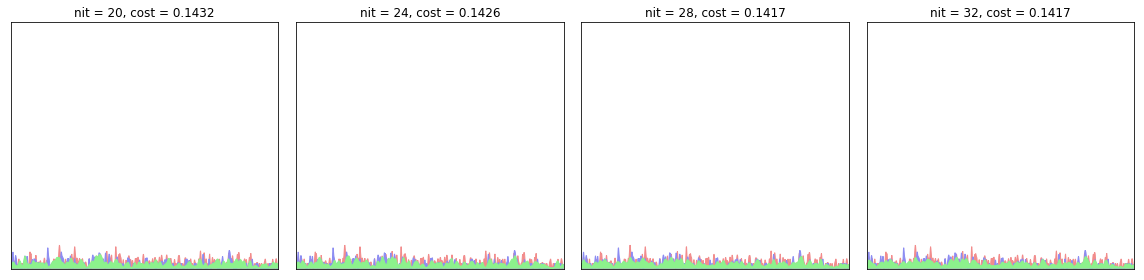

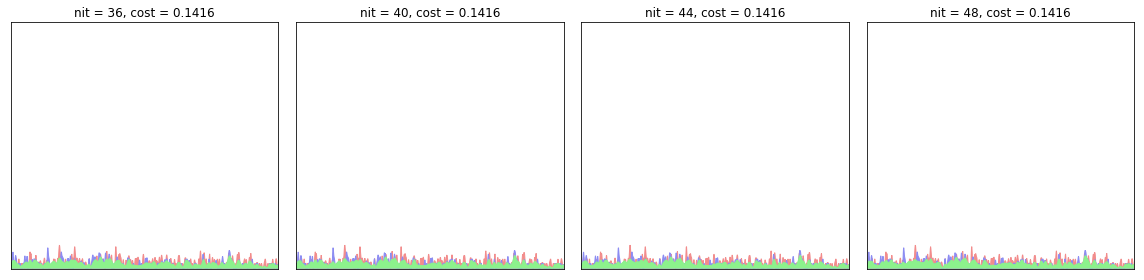

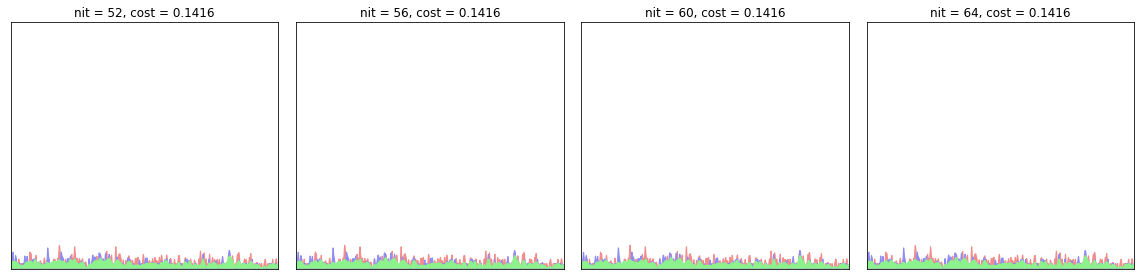

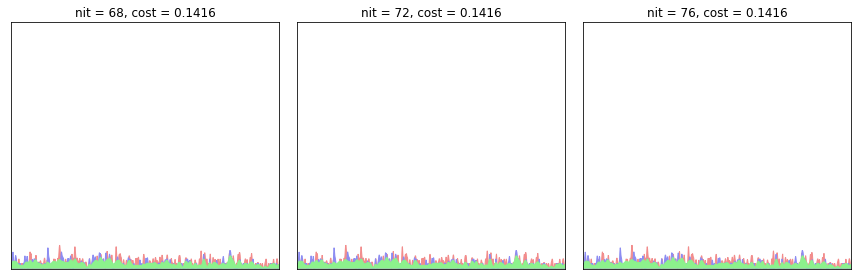

In [54]:
LB.fit(display=True)

In [55]:
weights = torch.nn.functional.softmax(EB.l_k, dim=0)
samples = EB.z_k
kde = KernelDensity(kernel='gaussian', bandwidth= .02).fit(EB.z_k.numpy(),
            sample_weight = weights.detach().numpy())
z_sampled = kde.sample(500) 

In [60]:
z_new = torch.from_numpy(z_sampled).double().view(1,-1,1)

In [62]:
z_new

tensor([[[ 0.9914],
         [-1.1110],
         [-0.3716],
         [-0.4711],
         [-1.6582],
         [ 1.1194],
         [ 0.2710],
         [ 0.1993],
         [-0.1240],
         [ 0.1571],
         [-0.2592],
         [-0.0658],
         [ 1.1877],
         [ 0.3472],
         [ 1.1199],
         [-0.7625],
         [-0.2465],
         [-0.0900],
         [ 0.4404],
         [ 0.9987],
         [-0.3536],
         [-0.6815],
         [ 1.5696],
         [-0.2176],
         [ 0.4804],
         [-1.4198],
         [ 0.4039],
         [ 0.3705],
         [ 0.3161],
         [ 1.1774],
         [ 0.3200],
         [ 0.3992],
         [ 0.3239],
         [-0.2120],
         [ 0.7162],
         [-0.5608],
         [ 1.7536],
         [ 0.9470],
         [ 0.9484],
         [ 0.4509],
         [ 1.0094],
         [ 0.2279],
         [ 1.0376],
         [ 0.2080],
         [-0.6804],
         [ 0.3508],
         [ 1.9796],
         [ 1.8149],
         [ 0.0035],
         [-0.7328],


In [63]:
model.to(torch.double)(z_new)

tensor([[-1.9903,  0.4785]], dtype=torch.float64, grad_fn=<AddmmBackward>)

In [66]:
model.to(torch.float)(X_i.view(1,-1,1))

tensor([[-1.8264,  0.3646]], grad_fn=<AddmmBackward>)

In [67]:
model.to(torch.float)(Y_j.view(1,-1,1))

tensor([[-2.2095,  0.7192]], grad_fn=<AddmmBackward>)

In [71]:
#weights1 = torch.nn.functional.softmax(LB.w, dim=0)
samples1 = LB.z_k
kde1 = KernelDensity(kernel='gaussian', bandwidth= .02).fit(LB.z_k.detach().numpy(),
            sample_weight = None)
z_sampled1 = kde1.sample(500) 

In [77]:
z_new1 = torch.from_numpy(z_sampled1).view(1,-1,1)

In [78]:
model.to(torch.float)(z_new1.to(torch.float))

tensor([[-1.9748,  0.5151]], grad_fn=<AddmmBackward>)